# Experimento 2
***
- Conjunto de Dados: VinBigData
- Analisando o efeito do valor médio de duas redes treinadas.

### Importação dos pacotes

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import urllib.request as url

url.urlretrieve('https://raw.githubusercontent.com/Alyssonmach/cnn-lung-diseases/main/assets/lung_segmentation.py', 
                'lung_segmentation.py')
from lung_segmentation import segmentation

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import cv2
import torch
import albumentations as A
from lungs_segmentation.pre_trained_models import create_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from lungs_segmentation.pre_trained_models import create_model
import lungs_segmentation.inference as inference
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import os

model_seg = create_model("resnet34", )

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model_seg = model_seg.to(device)

def segmentation(image, path = 'image.png'):

  image = tf.keras.preprocessing.image.array_to_img(image)
  tf.keras.preprocessing.image.save_img(path, image)
  image, mask = inference.inference(model_seg, path, 0.2)
  os.remove(path)
  for values_i in range(0, len(mask[0])):
    for values_j in range(0, len(mask[0])):
      if (mask[0, values_i, values_j] + mask[1, values_i, values_j]) == 0:
        image[values_i, values_j, 0] = 0
        image[values_i, values_j, 1] = 0
        image[values_i, values_j, 2] = 0
  
  return image

### Pré-processamento nos dados

In [3]:
# lendo os dados de um arquivo csv
dataframe = pd.read_csv('/content/drive/MyDrive/vinbigdata/train.csv')
# criando uma coluna com os caminhos relativos as imagens
dataframe['image_path'] = '/content/drive/MyDrive/vinbigdata/train/' + dataframe.image_id + '.jpg'

In [4]:
print('total de imagens disponíveis:', str(len(set(dataframe['image_path']))))

total de imagens disponíveis: 15000


In [5]:
# visualizando os casos disponíveis
dataframe['class_name'].value_counts()

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [6]:
# removendo os casos não relativos a distúrbios pulmonares
dataframe = dataframe[dataframe.class_name != 'Aortic enlargement']
dataframe = dataframe[dataframe.class_name != 'Cardiomegaly']
dataframe = dataframe[dataframe.class_name != 'Other lesion']
dataframe = dataframe[dataframe.class_name != 'Consolidation']

In [7]:
# separando os casos rotulados como normais e anormais
normal_cases = dataframe[(dataframe.class_id == 14) & (dataframe.class_name == 'No finding')]
abnormal_cases = dataframe[(dataframe.class_id != 14) & (dataframe.class_name != 'No finding')]

print('total de dados após a filtração:', str(len(set(normal_cases['image_path'])) + len(set(abnormal_cases['image_path']))))

total de dados após a filtração: 13948


In [8]:
# removendo as imagens repetidas
normal_data = normal_cases[['image_path', 'class_name']].drop_duplicates(subset = 'image_path', )
abnormal_data = abnormal_cases[['image_path', 'class_name']].drop_duplicates(subset = 'image_path', )

# criando dataframes especifos com caminhos para as imagens e rótulos
normal_data['target'] = 'normal'
abnormal_data['target'] = 'abnormal'

In [9]:
print('quantidade de dados rotulados como normais:', len(normal_data))
print('quantidade de dados rotulados como anormais:', len(abnormal_data))

quantidade de dados rotulados como normais: 10606
quantidade de dados rotulados como anormais: 3342


In [10]:
# removendo 69% dos casos normais para balancear os dados
normal, _ = train_test_split(normal_data, test_size = 0.69, random_state = 42)

In [11]:
print('quantidade de dados rotulados como normais:', len(normal))
print('quantidade de dados rotulados como anormais:', len(abnormal_data))

quantidade de dados rotulados como normais: 3287
quantidade de dados rotulados como anormais: 3342


In [12]:
# concatenando os dataframes de casos normais e anormais
full_data = pd.concat([normal, abnormal_data])

In [13]:
fibrosis = full_data[full_data.class_name == 'Pulmonary fibrosis']
fibrosis['finding_labels'] =  'yes'
others = full_data[full_data.class_name != 'Pulmonary fibrosis']
others = full_data[full_data.class_name != 'No finding']
others['finding_labels'] = 'no'
full_data = pd.concat([fibrosis, others])

In [14]:
# misturando todos os dados do dataframe e reiniciando os valores dos índices 
full_data = full_data.sample(frac = 1, axis = 0, random_state = 42).reset_index(drop=True)

In [15]:
# separando os dados de treinamento e de teste
train_df, test_df = train_test_split(full_data, stratify = full_data['finding_labels'],
                                     test_size = 0.2, random_state = 42)

In [16]:
# separando os dados de validação dos dados de treinamento
train_df, validation_df = train_test_split(train_df, stratify = train_df['finding_labels'],
                                           test_size = 0.2, random_state = 42)

In [17]:
# visualizando a quantidade de dados
print('quantidade de imagens de treinamento:', len(train_df['image_path']))
print('quantidade de rótulos de treinamento:', len(train_df['target']))
print('quantidade de imagens de teste:', len(test_df['image_path']))
print('quantidade de rótulos de teste:', len(test_df['target']))
print('quantidade de imagens de validação:', len(validation_df['image_path']))
print('quantidade de rótulos de validação:', len(validation_df['target']))

quantidade de imagens de treinamento: 2616
quantidade de rótulos de treinamento: 2616
quantidade de imagens de teste: 818
quantidade de rótulos de teste: 818
quantidade de imagens de validação: 654
quantidade de rótulos de validação: 654


In [18]:
# visualizando a quantidade de exemplos disponíveis nos dados de treinamento
train_df['finding_labels'].value_counts()

no     2138
yes     478
Name: finding_labels, dtype: int64

In [19]:
# visualizando a quantidade de exemplos disponíveis nos dados de validação
validation_df['finding_labels'].value_counts()

no     535
yes    119
Name: finding_labels, dtype: int64

In [20]:
# visualizando a quantidade de exemplos disponíveis nos dados de teste
test_df['finding_labels'].value_counts()

no     669
yes    149
Name: finding_labels, dtype: int64

In [21]:
# normalizando as imagens de treinamento e aplicando aumento de dados
image_generator = ImageDataGenerator(preprocessing_function = segmentation)

# criando o gerador de imagens de treinamento 
train_generator = image_generator.flow_from_dataframe(
                                                      dataframe = train_df,
                                                      directory = '',
                                                      x_col = 'image_path',
                                                      y_col = 'finding_labels',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'categorical',
                                                      target_size = (512, 512))

valid_datagen = ImageDataGenerator()
# criando o gerador de imagens de validação 
valid_generator = valid_datagen.flow_from_dataframe(
                                                      dataframe = validation_df,
                                                      directory = '.', 
                                                      x_col = 'image_path',
                                                      y_col = 'finding_labels',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'categorical',
                                                      target_size = (512, 512))

# normalizando as imagens de teste 
test_datagen = ImageDataGenerator(preprocessing_function = segmentation)

test_generator = test_datagen.flow_from_dataframe(
                                                  dataframe = test_df, 
                                                  directory = '.',
                                                  x_col = 'image_path',
                                                  y_col = 'finding_labels',
                                                  batch_size = 32,
                                                  seed = 42,
                                                  shuffle = True,
                                                  class_mode = 'categorical',
                                                  target_size = (512, 512))

Found 2616 validated image filenames belonging to 2 classes.
Found 654 validated image filenames belonging to 2 classes.
Found 818 validated image filenames belonging to 2 classes.


In [22]:
# visualizando os atributos numéricos nos dados de treinamento
train_generator.class_indices

{'no': 0, 'yes': 1}

### Preparando a rede neural convolucional

In [23]:
model = MobileNetV2(input_shape = (512, 512, 3), include_top = False, weights = 'imagenet', 
                    classes = 2, classifier_activation = 'softmax')
x = tf.keras.layers.GlobalAveragePooling2D()(model.output)
x = tf.keras.layers.Dense(units = 512, activation = 'relu')(x)
x = tf.keras.layers.Dense(units = 216, activation = 'relu')(x)
x = tf.keras.layers.Dropout(rate = 0.2)(x)
x = tf.keras.layers.Dense(units = 2, activation = 'softmax')(x)

model = tf.keras.models.Model(inputs = model.input, outputs = x)

In [28]:
# definindo o caminho pelo qual os pesos serão armazenados 
filepath = "/content/drive/MyDrive/experimentos/multilabel/fibrosis/transferlearning_weights.hdf5"
# callback para salvar o melhor valor dos pesos em relação ao desempenho com os dados de validação 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [29]:
# definindo um array de callbacks
callbacks = [checkpoint]

In [26]:
# compilando a rede 
model.compile(optimizer = optimizers.RMSprop(learning_rate = 0.0001), loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [27]:
# treinando a rede neural convolucional
history = model.fit_generator(train_generator, steps_per_epoch = 2616 // 32, 
                              validation_data = valid_generator, validation_steps = 654 // 32,
                              callbacks = callbacks, epochs = 3)

Epoch 1/3
81/81 [==============================] - 2610s 32s/step - loss: 0.4943 - acc: 0.8141 - val_loss: 0.4825 - val_acc: 0.8219

Epoch 00001: val_acc improved from -inf to 0.82187, saving model to /content/drive/MyDrive/experimentos/multilabel/fibrosis/transferlearning_weights.hdf5


OSError: ignored

In [30]:
# treinando a rede neural convolucional
history = model.fit_generator(train_generator, steps_per_epoch = 2616 // 32, 
                              validation_data = valid_generator, validation_steps = 654 // 32,
                              callbacks = callbacks, epochs = 3)

Epoch 1/3
11/81 [===>..........................] - ETA: 31:22 - loss: 0.4530 - acc: 0.7983

KeyboardInterrupt: ignored

In [31]:
(x,y) = train_generator[0]

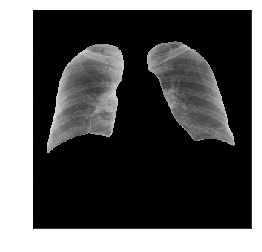

In [39]:
plt.imshow(x[2])